https://www.kaggle.com/code/mejbahahammad/movie-recommender-systems-using-neural-network/notebook

# Recommender Systems

we will use RBMs to build a recommender system, one of
the most successful applications of machine learning to date and widely
used in industry to help predict user preferences for movies, music, books,
news, search, shopping, digital advertising, and online dating.
There are two major categories of recommender systems—collaborative
filtering recommender systems and content-based filtering recommender
systems. Collaborative filtering involves building a recommender system
from a user’s past behavior and those of other users to which the user is
similar to. This recommender system can then predict items that the user
may have an interest in even though the user has never expressed explicit
interest. Movie recommendations on Netflix rely on collaborative filtering.
Content-based filtering involves learning the distinct properties of an item
to recommend additional items with similar properties. Music
recommendations on Pandora rely on content-based filtering.

# Collaborative Filtering

Content-based filtering is not commonly used because it is a rather difficult
task to learn the distinct properties of items—this level of understanding is
very challenging for artificial machines to achieve currently. It is much
easier to collect and analyze a large amount of information on users’
behaviors and preferences and make predictions based on this. Therefore,
collaborative filtering is much more widely used and is the type of
recommender system we will focus on here.

Collaborative filtering requires no knowledge of the underlying items
themselves. Rather, collaborative filtering assumes that users that agreed in
the past will agree in the future and that user preferences remain stable over
time. By modeling how similar users are to other users, collaborative
filtering can make pretty powerful recommendations. Moreover,
collaborative filtering does not have to rely on explicit data (i.e., ratings that
users provide). Rather, it can work with implicit data such as how long or
how often a user views or clicks on a particular item. For example, in the
past Netflix asked users to rate movies but now uses implicit user behavior
to make inferences about user likes and dislikes.

However, collaborative filtering has its challenges. First, it requires a lot of
user data to make good recommendations. Second, it is a very
computationally demanding task. Third, the datasets are generally very
sparse since users will have exhibited preferences for only a small fraction
of all the items in the universe of possible items. Assuming we have enough
data, there are techniques we can use to handle the sparsity of the data and
efficiently solve the problem, which we will cover in this chapter.

# MovieLens Dataset

Instead of the 100 million ratings Netflix dataset, we will use a smaller
movie ratings dataset known as the MovieLens 20M Dataset, provided by
GroupLens, a research lab in the Department of Computer Science and
Engineering at the University of Minnesota, Twin Cities. The data contains
20,000,263 ratings across 27,278 movies created by 138,493 users from
January 9, 1995 to March 31, 2015. Of users who rated at least 20 movies
each, we will select a subset at random.
This dataset is more manageable to work with than the 100 million ratings
dataset from Netflix. Because the file size exceeds one hundred megabytes,
the file is not accessible on GitHub. You will need to download the file
directly from the MovieLens website.

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
# import lightgbm as lgb

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

# Load the data

In [2]:
# ratingDF = pd.read_csv('../input/movielens-20m-dataset/ratings.csv')
ratingDF = pd.read_csv("C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Notebooks/ratings/ratings.csv")

# Convert fields into appropriate data types

In [3]:
data = ratingDF.copy()
data.shape

(20000263, 4)

In [4]:
# tamano_muestra = 60000
# ratingDF = ratingDF.sample(n=tamano_muestra, random_state=42)  

Pasa el usuario ID, pelicula ID a entero, la puntuación a float y el timestamp lo pone en modo fecha y hora

In [5]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [6]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,"12/09/2023, 12:23:41"
1,1,29,3.5,"12/09/2023, 12:23:41"
2,1,32,3.5,"12/09/2023, 12:23:41"
3,1,47,3.5,"12/09/2023, 12:23:41"
4,1,50,3.5,"12/09/2023, 12:23:41"


Obtengo el número de usuarios y peliculas unico, tmabién el total de puntuaciones.
Por último la media de puntuaciones por usuario

In [7]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

In [8]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


Selecciona las 10000 peliculas con mayor puntuación
- groupby("movieId").count(): Agrupa las calificaciones por el identificador de la película y cuenta cuántas calificaciones tiene cada película.
- sort_values(by="rating", ascending=False): Ordena el resultado en orden descendente según el número de calificaciones.
- [0:1000].index: Selecciona las primeras 1000 películas después de ordenar y extrae sus identificadores.

- ratingDF.movieId.isin(movieIndex): Crea una máscara booleana que es True para las filas donde el identificador de la película está en movieIndex.
- ratingDF[ratingDF.movieId.isin(movieIndex)]: Filtra el conjunto de datos original (ratingDF) para incluir solo las filas correspondientes a las 1000 películas más populares.

In [9]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [10]:
ratingDFX2.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,"12/09/2023, 12:23:41"
1,1,29,3.5,"12/09/2023, 12:23:41"
2,1,32,3.5,"12/09/2023, 12:23:41"
3,1,47,3.5,"12/09/2023, 12:23:41"
4,1,50,3.5,"12/09/2023, 12:23:41"


Lo mismo que antes pero ahora selccion aleatoriamente los 10000 usuarios.

In [11]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [12]:
ratingDFX3.head()

,userId,movieId,rating,timestamp
4943,49,50,5.0,"12/09/2023, 12:23:41"
4944,49,163,3.5,"12/09/2023, 12:23:41"
4945,49,216,3.0,"12/09/2023, 12:23:41"
4946,49,296,5.0,"12/09/2023, 12:23:41"
4947,49,333,3.0,"12/09/2023, 12:23:41"


También reindexaremos movieID y userID a un rango de 1 a 1.000 para nuestro conjunto de datos reducido:

In [13]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

In [14]:
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [15]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

In [16]:
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [17]:
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

In [18]:
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,"12/09/2023, 12:23:41",1,1
1,49,163,3.5,"12/09/2023, 12:23:41",2,1
2,49,216,3.0,"12/09/2023, 12:23:41",3,1
3,49,296,5.0,"12/09/2023, 12:23:41",4,1
4,49,333,3.0,"12/09/2023, 12:23:41",5,1


Calculemos el número de usuarios únicos, películas únicas, valoraciones totales y número medio de valoraciones por usuario para nuestro conjunto de datos reducido:

In [19]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

In [20]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


Conjunto de entrenamiento

Conjunto de test

Conjunto de validación

Generemos un conjunto de prueba y un conjunto de validación a partir de este conjunto de datos reducido, de modo que cada conjunto de retención represente el 5% del conjunto de datos reducido:

In [21]:
X_train, X_test = train_test_split(ratingDFX3,
test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,
test_size=0.50, shuffle=True, random_state=2018)

In [22]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (81191, 6)
Shape of validation set: (4511, 6)
Shape of test set:  (4511, 6)


In [23]:
print('Size of train set:', X_train.size)
print('Size of validation set:',X_validation.size)
print('Size of test set: ',X_test.size)

Size of train set: 487146
Size of validation set: 27066
Size of test set:  27066


## Define the Cost Function: Mean Squared Error

Está creando una matriz ratings_train inicializada con ceros y luego la está llenando
con calificaciones de películas proporcionadas en el conjunto de entrenamiento X_train

In [24]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    # row[6]-1 --> El índice del usuario menos uno porque en las amtrices los indices empizan por 0 y en el datset por 1.
    # row[5]-1 --> El índice de la pelicual menos uno porque en las amtrices los indices empizan por 0 y en el datset por 1.

    #La posición usuario, pelicula tiene la puntuación del dataset.
    ratings_train[row[6]-1, row[5]-1] = row[3]

En este bloque de código, se está calculando y mostrando la "esparsez" de la matriz ratings_train. 

La esparsez se refiere a la proporción de elementos no nulos (diferentes de cero) en la matriz 

en comparación con el número total de elementos posibles.

In [25]:
sparsity = float(len(ratings_train.nonzero()[0]))  #Calcula el número total de elementos en la matriz multiplicando el número de filas por el número de columnas.
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1]) # Divide la cantidad de elementos no cero entre el número total de elementos, normalizando así la esparsez para que esté en el rango [0, 1].
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


In [26]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [27]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

# Perform Baseline Experiments

ratings_validation.nonzero():

- ratings_validation.nonzero() devuelve las coordenadas (índices) de los elementos no cero en la matriz ratings_validation. Este método devuelve dos arreglos, uno para las coordenadas de las filas y otro para las coordenadas de las columnas donde los elementos son diferentes de cero.
Indexación de ratings_validation:

- ratings_validation[ratings_validation.nonzero()] realiza la indexación de la matriz ratings_validation utilizando las coordenadas de los elementos no cero. Esto devuelve un array con los valores de las calificaciones correspondientes a las coordenadas no cero en la matriz de validación.

Flatten:

- .flatten() se utiliza para aplanar el array resultante a una dimensión. Esto es necesario porque ratings_validation.nonzero() devuelve coordenadas bidimensionales, pero actual_validation debe ser un array unidimensional que contenga las calificaciones reales.

In [28]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

Se está inicializando un array pred_validation con ceros, y luego se asigna el valor 3.5 a todos los elementos del array. Vamos a desglosar 

Esta inicialización se realiza comúnmente para establecer un punto de partida antes de que el modelo realice sus predicciones. Luego, durante el entrenamiento, el modelo ajustará estas predicciones para minimizar la función de pérdida en comparación con las calificaciones reales del conjunto de validación.

In [29]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [30]:
print("Mean  Squared Error is : ", mean_squared_error(pred_validation, actual_validation))

Mean  Squared Error is :  1.055420084238528


Está imputando predicciones para el conjunto de validación utilizando la media de las calificaciones no nulas en el conjunto de entrenamiento. La idea es llenar las calificaciones faltantes en el conjunto de validación con la media de las calificaciones observadas en el conjunto de entrenamiento. Este enfoque proporciona una manera simple de asignar valores a las calificaciones faltantes para evaluar el rendimiento del modelo en el conjunto de validación.

In [31]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [32]:
pred_validation = ratings_validation_prediction  [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


Realiza una imputación de predicciones para el conjunto de validación utilizando la media de las calificaciones no nulas en el conjunto de entrenamiento, pero lo hace por columna (por película) en lugar de por fila (por usuario). La diferencia en la forma de la matriz resultante (ratings_validation_prediction) es el resultado de esta transposición. Ambos enfoques proporcionan formas de imputar predicciones para evaluar el rendimiento del modelo en el conjunto de validación.

In [33]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [34]:
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


1. Embedding Layer en Redes Neuronales:

- En redes neuronales, una capa de embedding se utiliza para representar datos categóricos, como índices de usuarios o elementos, en un espacio de características continuas (vectores de números reales).
- En el contexto de un modelo de recomendación, los índices de usuarios y elementos (películas en este caso) son datos categóricos que se deben convertir en representaciones numéricas continuas.

2. Parámetros de la Capa de Embedding:

- input_dim: Especifica el tamaño del vocabulario de entrada, es decir, el número total de usuarios únicos en este caso. Se añade 1 porque los índices suelen comenzar desde 1 en lugar de 0.
- output_dim: Determina la dimensión del espacio de embedding, es decir, el número de factores latentes que se están utilizando para representar a cada usuario. Este valor es un hiperparámetro ajustable y se ha establecido en 1 en tu código.

3. Entrada y Salida de la Capa:

- user_input: Es la entrada que representa al usuario. En este caso, es un tensor de forma (batch_size, 1), donde cada elemento es el índice del usuario.
- user_embedding: Es la salida de la capa de embedding. Será un tensor de forma (batch_size, 1, output_dim), donde el último eje representa la representación continua del usuario en el espacio de factores latentes.

4. Nombre de la Capa:

- name='user_embedding': Proporciona un nombre identificativo a la capa. Este nombre es útil al inspeccionar o referenciar la capa más adelante en el código.

En resumen, la capa de embedding para usuarios convierte los índices de usuarios (datos categóricos) en vectores de números reales en un espacio de factores latentes. Estos vectores representan características no observadas (latent factors) que el modelo aprenderá durante el entrenamiento para hacer recomendaciones más precisas. La elección del número de factores latentes (output_dim) es un hiperparámetro crucial que afecta el rendimiento del modelo y suele ser sintonizado mediante validación cruzada u otras técnicas de ajuste de hiperparámetros.

In [35]:
# Definición del número de factores latentes
n_latent_factors = 1  # Se establece en 1 para representar características no observadas que el modelo aprenderá durante el entrenamiento.
print(f"Number of Latent Factors: {n_latent_factors}")

# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model = Model(inputs=[user_input, movie_input], outputs=product)
# Se define el modelo con las capas de entrada y salida especificadas.
print("Model Summary:")
model.summary()

# Compilación del modelo con la función de pérdida y optimizador
model.compile('adam', 'mean_squared_error')
# El modelo se compila utilizando el optimizador Adam y la función de pérdida de error cuadrático medio.
print("Model Compiled Successfully")

Number of Latent Factors: 1
User Input Shape: (None, 1)
User Embedding Shape: (None, 1, 1)
Flattened User Vector Shape: (None, 1)
Movie Input Shape: (None, 1)
Movie Embedding Shape: (None, 1, 1)
Flattened Movie Vector Shape: (None, 1)
Product Shape: (None, 1)
Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 1)         1001        ['movie[0][0]']                  
                 

In [36]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId],
                    y=X_train.rating, epochs=100,
                    validation_data=([X_validation.newUserId,
                                      X_validation.newMovieId], X_validation.rating),
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 5s 2ms/step - loss: 13.8092 - val_loss: 12.3057
Epoch 2/100
2538/2538 [==============================] - 4s 2ms/step - loss: 9.6048 - val_loss: 6.9443
Epoch 3/100
2538/2538 [==============================] - 5s 2ms/step - loss: 4.9470 - val_loss: 3.5293
Epoch 4/100
2538/2538 [==============================] - 5s 2ms/step - loss: 2.6815 - val_loss: 2.1367
Epoch 5/100
2538/2538 [==============================] - 5s 2ms/step - loss: 1.7095 - val_loss: 1.4830
Epoch 6/100
2538/2538 [==============================] - 5s 2ms/step - loss: 1.2301 - val_loss: 1.1562
Epoch 7/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.9882 - val_loss: 0.9887
Epoch 8/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8652 - val_loss: 0.9013
Epoch 9/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8013 - val_loss: 0.8533
Epoch 10/100
2538/2538 [==============================] - 5s 2ms/step -

Minimum MSE:  0.795692503452301


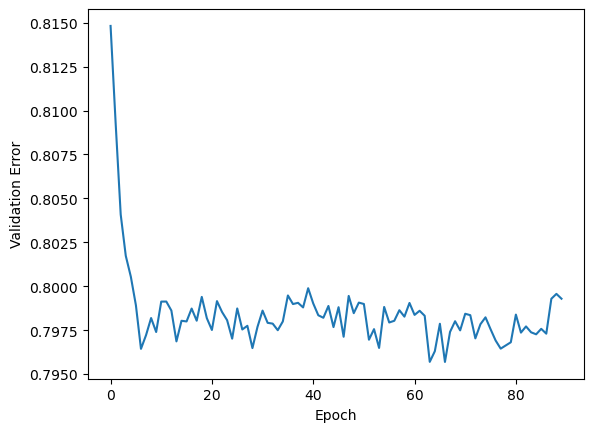

In [37]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

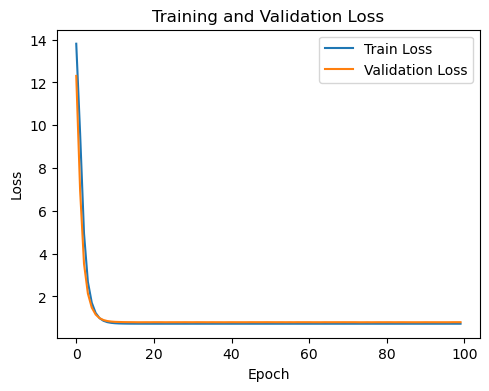

In [38]:
# Visualizar la pérdida
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [39]:
result = model.evaluate(
    x=[X_validation.newUserId, X_validation.newMovieId],
    y=X_validation.rating
)
print('MSE: ',result)


141/141 [==============================] - 0s 2ms/step - loss: 0.7993
MSE:  0.7992907166481018


In [40]:
predictions_proba = model.predict( x=[X_validation.newUserId, X_validation.newMovieId])
predictions_proba

141/141 [==============================] - 0s 2ms/step


array([[4.4047728],
       [4.3277636],
       [3.805338 ],
       ...,
       [3.0942767],
       [3.453238 ],
       [2.9194489]], dtype=float32)

# MODIFICADO

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [42]:
# Define la función R cuadrado personalizada para tensores de TensorFlow
from tensorflow.keras import backend as K

def r2_score_tf(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [43]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
# product = dot([movie_vec, user_vec], axes=1)
concatenated = Concatenate()([movie_vec, user_vec])

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_nonlinear_r2 = Model(inputs=[user_input, movie_input], outputs=output)

# Compila el modelo utilizando la función R cuadrado personalizada
model_nonlinear_r2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',r2_score_tf])

# Mostrar un resumen del modelo
model_nonlinear_r2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 1)         1001        ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 1)         1001        ['user[0][0]']                   
                                                                                              

In [44]:
# Entrenar el modelo
history_nonlinear_r2 = model_nonlinear_r2.fit(
    x=[X_train.newUserId, X_train.newMovieId],
    y=X_train.rating,
    epochs=150, 
    batch_size=64,
    validation_data=([X_validation.newUserId, X_validation.newMovieId], X_validation.rating),
    verbose=1
)


Epoch 1/150
1269/1269 [==============================] - 5s 3ms/step - loss: 1.1618 - mean_absolute_error: 0.7878 - r2_score_tf: -0.1391 - val_loss: 0.8015 - val_mean_absolute_error: 0.6790 - val_r2_score_tf: 0.2103
Epoch 2/150
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7463 - mean_absolute_error: 0.6634 - r2_score_tf: 0.2733 - val_loss: 0.8108 - val_mean_absolute_error: 0.6727 - val_r2_score_tf: 0.1996
Epoch 3/150
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7392 - mean_absolute_error: 0.6590 - r2_score_tf: 0.2787 - val_loss: 0.7932 - val_mean_absolute_error: 0.6813 - val_r2_score_tf: 0.2178
Epoch 4/150
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7357 - mean_absolute_error: 0.6581 - r2_score_tf: 0.2817 - val_loss: 0.8044 - val_mean_absolute_error: 0.6892 - val_r2_score_tf: 0.2056
Epoch 5/150
1269/1269 [==============================] - 4s 3ms/step - loss: 0.7346 - mean_absolute_error: 0.6572 - r2_score_tf: 0.2816 - v

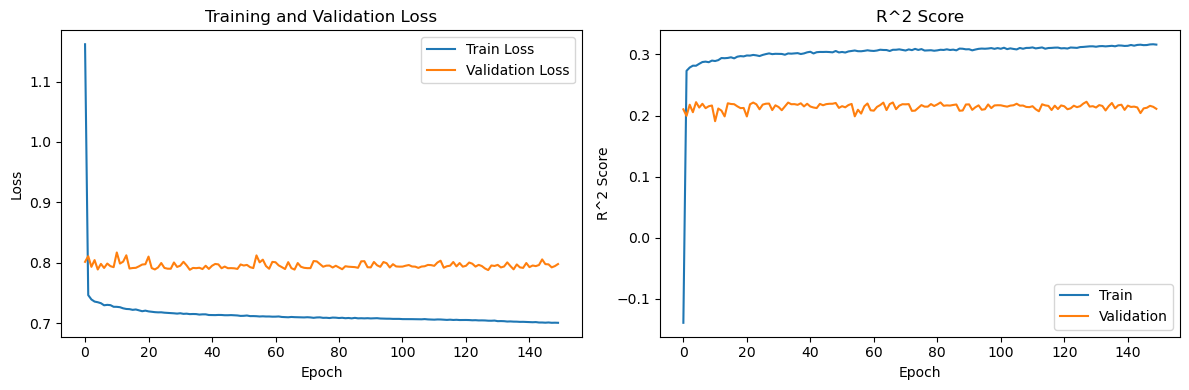

In [45]:
# Visualizar la pérdida y el R cuadrado en entrenamiento y validación
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_nonlinear_r2.history['loss'], label='Train Loss')
plt.plot(history_nonlinear_r2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Visualiza el R cuadrado en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history_nonlinear_r2.history['r2_score_tf'], label='Train')
plt.plot(history_nonlinear_r2.history['val_r2_score_tf'], label='Validation')
plt.title('R^2 Score')
plt.xlabel('Epoch')
plt.ylabel('R^2 Score')
plt.legend()

plt.tight_layout()
plt.show()

Minimum MSE:  0.7878415584564209


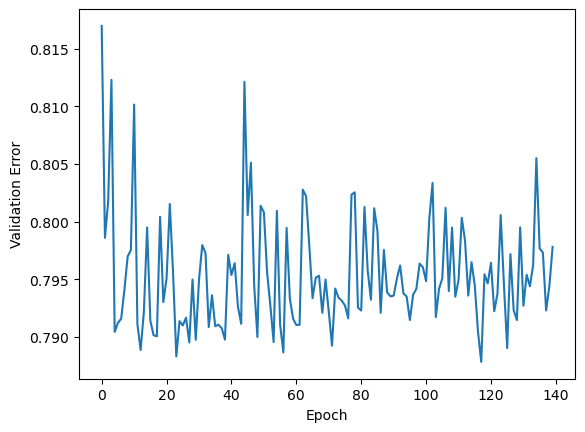

In [46]:
pd.Series(history_nonlinear_r2.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history_nonlinear_r2.history['val_loss']))

In [47]:
result = model_nonlinear_r2.evaluate(
    x=[X_validation.newUserId, X_validation.newMovieId],
    y=X_validation.rating
)
result

141/141 [==============================] - 0s 2ms/step - loss: 0.7978 - mean_absolute_error: 0.6742 - r2_score_tf: 0.1924


[0.7978188395500183, 0.6742026209831238, 0.1924155354499817]

In [48]:
predictions_proba = model_nonlinear_r2.predict( x=[X_validation.newUserId, X_validation.newMovieId])
predictions_proba

141/141 [==============================] - 0s 2ms/step


array([[4.4290304],
       [4.3328753],
       [3.9637847],
       ...,
       [3.0037334],
       [3.478292 ],
       [2.9382637]], dtype=float32)

In [49]:
# Obtener predicciones para el conjunto de prueba
predictions = model_nonlinear_r2.predict( x=[X_validation.newUserId, X_validation.newMovieId])

141/141 [==============================] - 0s 2ms/step


In [167]:
predictions

array([[4.4290304],
       [4.3328753],
       [3.9637847],
       ...,
       [3.0037334],
       [3.478292 ],
       [2.9382637]], dtype=float32)

Copio el datset de validación, coloco la columna de puntuación al final del datset, añado las predicciones y el error cometido en cada predicción

In [206]:
X_validation_with_predicitons = X_validation.copy()
X_validation_with_predicitons.insert(X_validation_with_predicitons.columns.get_loc(X_validation_with_predicitons.columns[-1]), 'rating', X_validation_with_predicitons.pop('rating'))
X_validation_with_predicitons['rating_predictions'] = predictions
X_validation_with_predicitons['error'] = X_validation_with_predicitons['rating'] - X_validation_with_predicitons['rating_predictions']
# X_validation_with_predicitons = X_validation_with_predicitons.drop(['timestamp'], axis=1)
X_validation_with_predicitons.head()

,userId,movieId,timestamp,newMovieId,newUserId,rating,rating_predictions,error
58632,104102,3578,"12/09/2023, 12:23:41",234,731,5.0,4.429030,0.570970
6501,20257,1284,"12/09/2023, 12:23:41",861,137,4.0,4.332875,-0.332875
45799,125007,2959,"12/09/2023, 12:23:41",64,893,5.0,3.963785,1.036215
7180,20579,5218,"12/09/2023, 12:23:41",379,145,4.0,3.517937,0.482063
143,311,546,"12/09/2023, 12:23:41",115,3,1.0,2.181641,-1.181641


In [196]:
userID = 5
num_movie_to_recomed = 5
group_by_userID  = X_validation_with_predicitons.groupby('newUserId').get_group(userID)
order_by_true_rating = group_by_userID.sort_values(by='rating', ascending=False)
order_by_predict_rating = group_by_userID.sort_values(by='rating_predictions', ascending=False)
df_group_by_user_order_rating_recommended_mov = order_by_true_rating.copy()
df_group_by_user_order_rating_recommended_mov['recommended_movies'] = order_by_predict_rating['newMovieId'].values
num_movie_to_recomed = len(df_group_by_user_order_rating_recommended_mov.newMovieId.unique())
num_movie_to_recomed = int(num_movie_to_recomed/2)
count_shared_movies = df_group_by_user_order_rating_recommended_mov.head(num_movie_to_recomed)['newMovieId'].isin(df_group_by_user_order_rating_recommended_mov.head(num_movie_to_recomed)['recommended_movies']).sum()
print(f"Recomendaría {count_shared_movies} de las {num_movie_to_recomed} películas que mejor a puntuado el usuario {df_group_by_user_order_rating_recommended_mov.newUserId.unique()[0]}")
df_group_by_user_order_rating_recommended_mov

Recomendaría 1 de las 2 películas que mejor a puntuado el usuario 5


,userId,movieId,timestamp,newMovieId,newUserId,rating,rating_predictions,error,recommended_movies
78463,499,329,"12/09/2023, 12:23:41",100,5,4.0,3.147219,0.852781,134
78480,499,1584,"12/09/2023, 12:23:41",274,5,4.0,3.434459,0.565541,274
78484,499,2407,"12/09/2023, 12:23:41",278,5,3.0,3.246878,-0.246878,278
78466,499,1196,"12/09/2023, 12:23:41",134,5,3.0,4.104556,-1.104556,100
78474,499,3623,"12/09/2023, 12:23:41",235,5,3.0,2.987844,0.012156,235


In [194]:
num_movie_saw_by_user = 0
num_movie_recommended_by_user = 0
n_users = X_validation_with_predicitons.userId.unique().shape[0]

for userID in X_validation_with_predicitons.newUserId.unique():
    group_by_userID  = X_validation_with_predicitons.groupby('newUserId').get_group(userID)
    order_by_true_rating = group_by_userID.sort_values(by='rating', ascending=False)
    order_by_predict_rating = group_by_userID.sort_values(by='rating_predictions', ascending=False)
    df_group_by_user_order_rating_recommended_mov = order_by_true_rating.copy()
    df_group_by_user_order_rating_recommended_mov['recommended_movies'] = order_by_predict_rating['newMovieId'].values
    num_movie_to_saw= len(df_group_by_user_order_rating_recommended_mov.newMovieId.unique())

    # num_movie_saw_by_user = num_movie_saw_by_user + num_movie_to_saw

    num_movie_to_recomed = int(num_movie_to_saw/2)

    num_movie_saw_by_user = num_movie_saw_by_user + num_movie_to_recomed

    count_shared_movies = df_group_by_user_order_rating_recommended_mov.head(num_movie_to_recomed)['newMovieId'].isin(df_group_by_user_order_rating_recommended_mov.head(num_movie_to_recomed)['recommended_movies']).sum()
    num_movie_recommended_by_user = num_movie_recommended_by_user + count_shared_movies
    # print(f"Recomendaría {count_shared_movies} de las {num_movie_to_recomed} películas que mejor a puntuado el usuario {df_group_by_user_order_rating_recommended_mov.newUserId.unique()[0]}")
    


mean_movie_saw_by_user = num_movie_saw_by_user/n_users
mean_movie_recommended_by_user = num_movie_recommended_by_user/n_users

print(f"El recomendador a recomendado correctamente un media de {round(mean_movie_recommended_by_user)} películas de una media de {round(mean_movie_saw_by_user)} ya vistas y puntuadas por los usuarios")

El recomendador a recomendado correctamente un media de 1 películas de una media de 2 ya vistas y puntuadas por los usuarios


Que porcentaje de peliculas predichas estan en la misma posción que las peliculas ordenadas por calificación (real)

In [208]:
userID = 5
num_movie_to_recomed = 5
group_by_userID  = X_validation_with_predicitons.groupby('newUserId').get_group(userID)
order_by_true_rating = group_by_userID.sort_values(by='rating', ascending=False)
order_by_predict_rating = group_by_userID.sort_values(by='rating_predictions', ascending=False)
df_group_by_user_order_rating_recommended_mov = order_by_true_rating.copy()
df_group_by_user_order_rating_recommended_mov['recommended_movies'] = order_by_predict_rating['newMovieId'].values
comparison_result = df_group_by_user_order_rating_recommended_mov['newMovieId'] == df_group_by_user_order_rating_recommended_mov['recommended_movies']
count_true_false = comparison_result.value_counts()
if True in count_true_false.index:
    porcentaje_aciertos = count_true_false[True] / len(df_group_by_user_order_rating_recommended_mov) * 100
else:
    porcentaje_aciertos = 0
print(f"El porcentaje de aciertos en la ordenación de peliculas para el usuario  {df_group_by_user_order_rating_recommended_mov.newUserId.unique()[0]} es de {porcentaje_aciertos}%")
df_group_by_user_order_rating_recommended_mov

El porcentaje de aciertos en la ordenación de peliculas para el usuario  5 es de 60.0%


,userId,movieId,timestamp,newMovieId,newUserId,rating,rating_predictions,error,recommended_movies
78463,499,329,"12/09/2023, 12:23:41",100,5,4.0,3.147219,0.852781,134
78480,499,1584,"12/09/2023, 12:23:41",274,5,4.0,3.434459,0.565541,274
78484,499,2407,"12/09/2023, 12:23:41",278,5,3.0,3.246878,-0.246878,278
78466,499,1196,"12/09/2023, 12:23:41",134,5,3.0,4.104556,-1.104556,100
78474,499,3623,"12/09/2023, 12:23:41",235,5,3.0,2.987844,0.012156,235


In [213]:
sum_percent = 0
for userID in X_validation_with_predicitons.newUserId.unique():
    group_by_userID  = X_validation_with_predicitons.groupby('newUserId').get_group(userID)
    order_by_true_rating = group_by_userID.sort_values(by='rating', ascending=False)
    order_by_predict_rating = group_by_userID.sort_values(by='rating_predictions', ascending=False)
    df_group_by_user_order_rating_recommended_mov = order_by_true_rating.copy()
    df_group_by_user_order_rating_recommended_mov['recommended_movies'] = order_by_predict_rating['newMovieId'].values
    comparison_result = df_group_by_user_order_rating_recommended_mov['newMovieId'] == df_group_by_user_order_rating_recommended_mov['recommended_movies']
    count_true_false = comparison_result.value_counts()
    if True in count_true_false.index:
        porcentaje_aciertos = count_true_false[True] / len(df_group_by_user_order_rating_recommended_mov) * 100
    else:
        porcentaje_aciertos = 0
    # print(f"El porcentaje de aciertos en la ordenación de peliculas para el usuario  {df_group_by_user_order_rating_recommended_mov.newUserId.unique()[0]} es de {porcentaje_aciertos}%")
    sum_percent = sum_percent + porcentaje_aciertos

total = len(X_validation_with_predicitons.newUserId.unique())

print(f"El porcentaje medio de aciertos es de {round(sum_percent/total)}%")

El porcentaje medio de aciertos es de 49%
